# Image Segmentation using U-NET algorithm

In [1]:
#Importing libraries :

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [5]:
#importing data:

# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)




Shuffling and writing examples to C:\Users\PMLS\tensorflow_datasets\oxford_iiit_pet\3.1.0.incompleteDGIYL1\oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to C:\Users\PMLS\tensorflow_datasets\oxford_iiit_pet\3.1.0.incompleteDGIYL1\oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to C:\Users\PMLS\tensorflow_datasets\oxford_iiit_pet\3.1.0. Subsequent calls will reuse this data.
name: "oxford_iiit_pet"
description: "The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200\nimages for each class. The images have large variations in scale, pose and\nlighting. All images have an associated ground truth annotation of breed."
citation: "@InProceedings{parkhi12a,\n  author       = \"Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Jawahar, C.~V.\",\n  title        = \"Cats and Dogs\",\n  booktitle    = \"IEEE Conference on Computer Vision and Pattern Recognition\",\n  year         = \"2012\",\n}"
size_in_bytes: 840161280
lo

2024-02-03 11:47:38.010276: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

I0203 11:47:44.196759  3964 download_and_prepare.py:193] Running download_and_prepare for dataset(s):
oxford_iiit_pet:3.1.0
W0203 11:47:44.200348  3964 dataset_builder.py:661] Found a different version of the requested dataset:
C:\Users\PMLS\tensorflow_datasets\oxford_iiit_pet\3.2.0
Using C:\Users\PMLS\tensorflow_datasets\oxford_iiit_pet\3.1.0 instead.
I0203 11:47:45.058852  3964 dataset_info.py:429] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: oxford_iiit_pet/3.1.0
I0203 11:47:47.883208  3964 dataset_info.py:361] Load dataset info from C:\Users\PMLS\AppData\Local\Temp\tmpdtjdx4_ltfds
I0203 11:47:47.891793  3964 dataset_info.py:399] Field info.description from disk and f

In [4]:
print(dataset.keys())

NameError: name 'dataset' is not defined

In [ ]:
# preprocessing data :

#image agumentation

def random_flip (input_image , input_mask):
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

        
    return input_image, input_mask

# normalizing the input images:

def image_normalize(input_image, input_mask):
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    input_mask -=1       # to have range between [0 , 1 , 2 ..]
    
    return input_image , input_mask

# Loading the train images :

def load_image_train(datapoint):
    
    input_image = tf.image.resize(datapoint['image'] , (128 , 128) , method= 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'] , (128 , 128) , method= 'nearest')
    
    input_image , input_mask = random_flip(input_image , input_mask)   
    input_image , input_mask = image_normalize(input_image , input_mask) 
    
    return input_image , input_mask
    
#loading the test images :

def load_image_test(datapoint):
    
    test_image = tf.image.resize(datapoint['image'] , (128 , 128) , method= 'nearest')
    test_mask = tf.image.resize(datapoint['segmentation_mask'] , (128 , 128) , method= 'nearest')
    
    test_image , test_mask = image_normalize(test_image , test_mask)
    
    return test_image , test_mask


In [ ]:
train_dataset = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test)


BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Shuffle and batch the train set
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# Prefetch for optimization
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Batch the test set
test_dataset = test_dataset.batch(BATCH_SIZE)


In [83]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''
  
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 


def display(display_list,titles=[], display_string=None):
  '''displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()


def show_image_from_dataset(dataset):
  '''displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

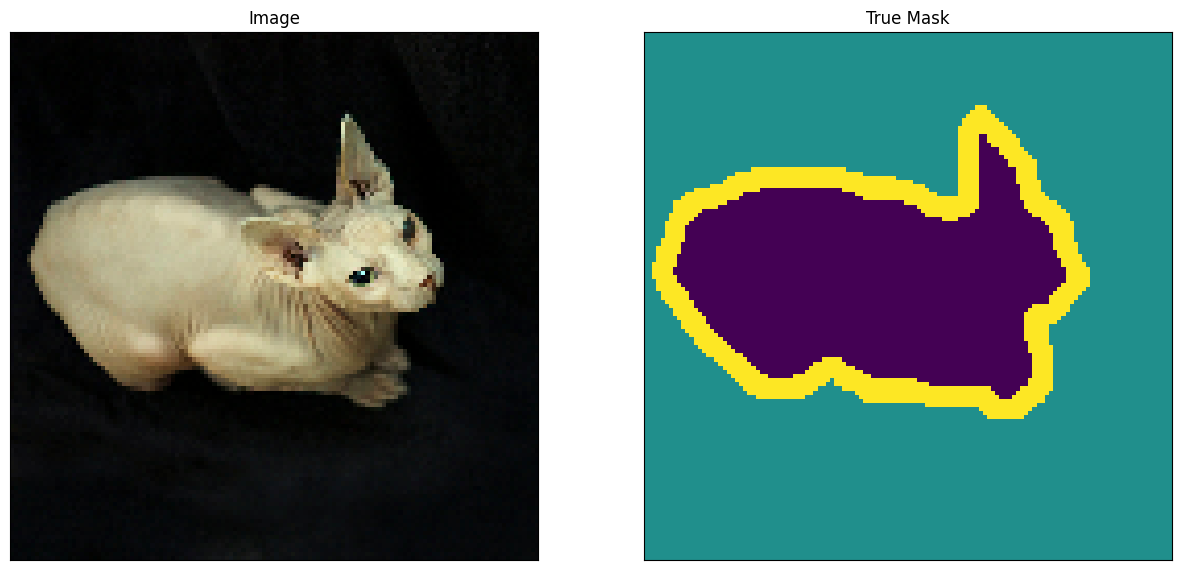

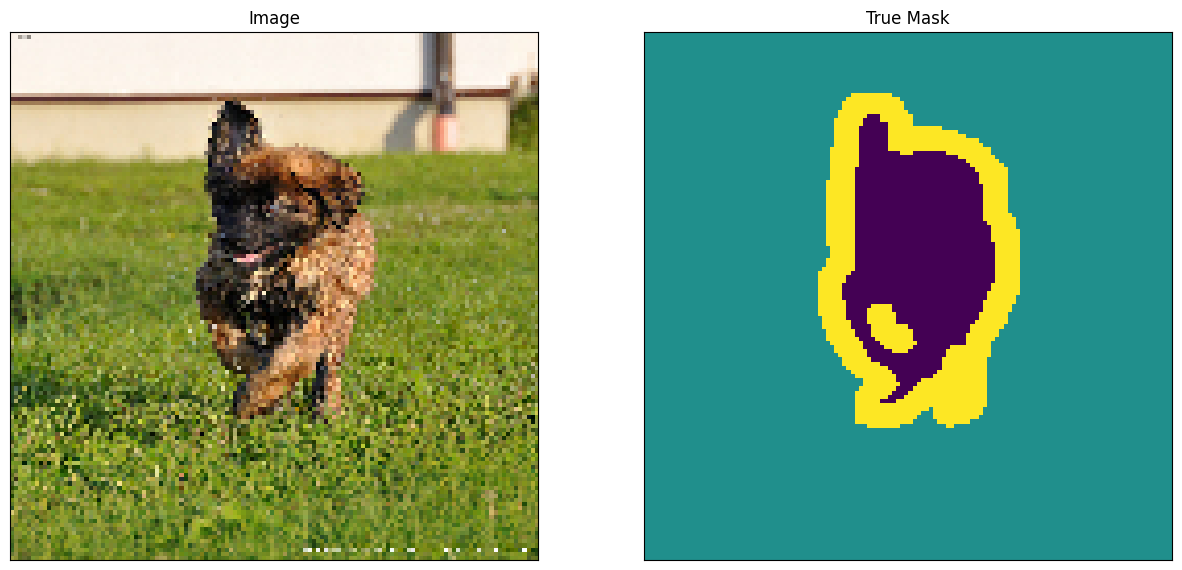

In [84]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

In [91]:
#Encoder Utils :

def conv2D_block(input_image , n_filters , kernel_size = 3):
    
    # Adding two convolution layers:
    
    x = input_image
    
    for i in range(2):
        
        x = tf.keras.layers.Conv2D(
                filters=n_filters,
                kernel_size=(kernel_size, kernel_size),
                kernel_initializer='he_normal',
                padding="same")(x)

        
        x = tf.keras.layers.Activation('relu')(x)
        
    return x

def max_pool(inputs , n_filters , pool_size ):
    
    c = conv2D_block(inputs , n_filters = n_filters)        #output of conv2D_block
    
    p = tf.keras.layers.MaxPooling2D( pool_size = pool_size) (c)
    
    p = tf.keras.layers.Dropout(0.3)(p)
    
    return c , p

def encoder(inputs ):
    
    f1 , p1 = max_pool(inputs , n_filters = 64 , pool_size = (2 , 2)  )
    
    f2 , p2 = max_pool(p1 , n_filters = 128 , pool_size= (2 , 2) )
    
    f3 , p3 = max_pool(p2, n_filters = 256 , pool_size= (2 , 2) )
    
    f4 , p4 = max_pool(p3 , n_filters = 512 , pool_size= (2 , 2) )
    
    return p4 , (f1 , f2 , f3 , f4)


In [92]:
# Bottle neck:

def bottle_neck(input):

    bottle_neck = conv2D_block(input , n_filters = 1024)
    
    return bottle_neck


In [102]:
#Decoder:

def up_sampling(inputs , conv_output , n_filters = 64 , kernel_size = (3 , 3) , strides = (2 , 2) , dropout = 0.3):
    
    
    up_sampling_layer = tf.keras.layers.Conv2DTranspose(
                                        n_filters,
                                        kernel_size,
                                        padding="same",
                                        strides = strides )(inputs)
    
    c = tf.keras.layers.concatenate([up_sampling_layer , conv_output])
    
    c = tf.keras.layers.Dropout( dropout )(c)
    
    c = conv2D_block(c , n_filters , kernel_size = 3)
    
    return c
    

In [103]:
def decoder(inputs , convs , output_channels ):
    
    f1 , f2 , f3 , f4  = convs
    
    c6 = up_sampling(inputs , f4 , n_filters = 512 ,  kernel_size= (3 , 3) , strides = (2 , 2) , dropout = 0.3)
    
    c7 = up_sampling(c6 , f3 , n_filters = 256 ,  kernel_size= (3 , 3) , strides = (2 , 2) , dropout = 0.3)
    
    c8 = up_sampling(c7 , f2 , n_filters = 128 ,  kernel_size= (3 , 3) , strides = (2 , 2) , dropout = 0.3)
    
    c9 = up_sampling(c8 , f1 , n_filters = 64 ,  kernel_size= (3 , 3) , strides = (2 , 2) , dropout = 0.3)
    
    outputs = tf.keras.layers.Conv2D(output_channels , (1 , 1) , activation = "softmax")(c9)
    
    return outputs

In [104]:
#combining them together:


OUTPUT_CHANNELS = 3

def unet():
    
    # Defining the input shape 
    
    inputs = tf.keras.layers.Input(shape = ( 128 , 128 ,3))
    
    p4 , convs = encoder(inputs)   
         
    bottleneck = bottle_neck(p4)
    
    outputs = decoder(bottleneck , convs , output_channels= OUTPUT_CHANNELS )
    
    model = tf.keras.Model(inputs =inputs , outputs = outputs)
    
    return model


model = unet()

model.summary()
    
    
    

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_64 (Conv2D)          (None, 128, 128, 64)         1792      ['input_21[0][0]']            
                                                                                                  
 activation_58 (Activation)  (None, 128, 128, 64)         0         ['conv2d_64[0][0]']           
                                                                                                  
 conv2d_65 (Conv2D)          (None, 128, 128, 64)         36928     ['activation_58[0][0]']       
                                                                                            

In [105]:
# config the optimizer , loss and metrices 

model.compile(optimizer = tf.keras.optimizers.Adam() , loss = 'sparse_categorical_crossentropy' , metrics = 'accuracy')

In [106]:
# Train the model :

TRAIN_LENGTH = info.splits['train'].num_examples

EPOCHS = 10 

VAL_SUBSPLITS = 5

STEPS_PER_EPOCH = TRAIN_LENGTH //  BATCH_SIZE

model_histoey = model.fit(train_dataset , epochs = EPOCHS ,
                          
                          steps_per_epoch = STEPS_PER_EPOCH ,
                          
                          validation_steps = VAL_SUBSPLITS ,
                          
                          validation_data = test_dataset )

Epoch 1/10



 6/57 [==>...........................] - ETA: 42:48 - loss: 1.1493 - accuracy: 0.5084


KeyboardInterrupt



In [ ]:
# Plot training and validation loss:

plot_metrics('loss' , title = "Training vs Validation" , ylim = 1)

In [1]:
# Prediction Utilities :

def get_test_image_and_annotation_arrays():
    
    ds = test_dataset.unbatch()
    
    ds = ds.batch(info.splits['test'].num_examples)
    
    images = []
    
    y_true_segments = []
    
    for image , annotation in ds.take(1):
        
        y_true_segments = annotation.np()
        
        images = image.numpy()
        
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
        
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments
        

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask , axis = -1)
    
    pred_mask = pred_mask[... , tf.newaxis]
    
    return pred_mask[0].numpy()

def make_predictions(image , mask , num = 1):
    
    image = np.reshape(image , (1 , image.shape[0] , image.shape[1] , image.shape[2]))
    
    pred_mask = model.predict(image)
    
    pred_mask = create_mask(pred_mask)
    
    return pred_mask

In [ ]:
# Compute class wise metrics :

def class_wise_metrics(y_true , y_pred):
    
    class_wise_iou = []             # Intersection over union 
    
    class_wise_dice_score = []      # Dice score method
    
    smoothening_factor = 0.00001
    
    for i in range(3) :
        
        intersection = np.sum((y_pred == i) * (y_true == i))
        
        y_true_area = np.sum((y_true == i) )
        
        y_pred_area = np.sum((y_pred == i) )    
        
        combined_area = y_pred_area + y_true_area
        
        
        iou = (intersection + smoothening_factor) / (combined_area + smoothening_factor)
        
        class_wise_iou.append(iou)
        
        dice_score = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        
        class_wise_dice_score.append(dice_score)
        
    return class_wise_iou , class_wise_dice_score


    

In [ ]:
# get the ground truth from the test set

y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks

results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)

results = np.argmax(results, axis=3)

results = results[..., tf.newaxis]

In [ ]:
# compute the class wise metrics

cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
# show the IOU for each class

for idx, iou in enumerate(cls_wise_iou):
    
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

In [ ]:
# show the Dice Score for each class

for idx, dice_score in enumerate(cls_wise_dice_score):
    
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

In [ ]:
# Please input a number between 0 to 3647 to pick an image from the dataset

integer_slider = 3646

# Get the prediction mask

y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics

iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images

display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)